# Carga de librerías

In [1]:
import pandas as pd
import numpy as np # versión 1.26.4 incompatible con opencv-python 4.12.0.88
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point
from PIL import Image
import squarify
import colorsys
import json
import os
from os import listdir
from os.path import isfile, join
from collections import Counter
import re
import warnings
from pathlib import Path
from glob import glob

warnings.filterwarnings(action='ignore', category=FutureWarning, 
                        message=r".*Use a DatetimeIndex.*")

warnings.filterwarnings(action='ignore', category=UserWarning)
pd.options.mode.copy_on_write = True


# Data load

In [2]:
metadata_raw_data_fn = "/home/joan_ds/Sandbox/UOC/TFM/2025-09-23-11-35-18_biaa_metadata_export.csv"
metadata_raw_data = pd.read_csv(metadata_raw_data_fn, sep=";",
                                parse_dates=['Date_Time'], date_format="mixed", dayfirst=True)

metadata_raw_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3302 entries, 0 to 3301
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date_Time             3302 non-null   datetime64[ns]
 1   Photo file Name       3302 non-null   object        
 2   Direction             3302 non-null   int64         
 3   Latitude              3302 non-null   float64       
 4   Longitude             3302 non-null   float64       
 5   Position Accuracy     3302 non-null   object        
 6   Altitude              3302 non-null   object        
 7   Datum                 3302 non-null   object        
 8   Capture Mode Details  3302 non-null   object        
 9   Project Name          29 non-null     object        
 10  Photo Description     2424 non-null   object        
 11  Watermark             0 non-null      float64       
 12  Tilt                  3302 non-null   object        
 13  Roll              

In [3]:
ann_gt_data_fn = "/home/joan_ds/Sandbox/UOC/TFM/LabelMe/GT-500_post_rev.xlsx"
ann_gt_data = pd.read_excel(ann_gt_data_fn)
ann_gt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   file_name                  507 non-null    object 
 1   time_no_SAM                507 non-null    int64  
 2   time_pred                  507 non-null    float64
 3   time_test                  0 non-null      float64
 4   n_masks_gt                 507 non-null    int64  
 5   n_masks_pred               507 non-null    int64  
 6   n_masks_edited             0 non-null      float64
 7   n_masks_added              0 non-null      float64
 8   n_masks_deleted            0 non-null      float64
 9   view                       0 non-null      float64
 10  night                      0 non-null      float64
 11  dry                        0 non-null      float64
 12  shadows                    0 non-null      float64
 13  sidewalk_pavement_anomaly  0 non-null      float64

In [4]:
mypaths = ['/home/joan_ds/Sandbox/UOC/TFM/data/dataset_500_GT/segmaps/test',
           '/home/joan_ds/Sandbox/UOC/TFM/data/dataset_500_GT/segmaps/val',
           '/home/joan_ds/Sandbox/UOC/TFM/data/dataset_500_GT/segmaps/train']
test_files = [f for f in listdir(mypaths[0]) if isfile(join(mypaths[0], f))]
val_files = [f for f in listdir(mypaths[1]) if isfile(join(mypaths[1], f))]
train_files = [f for f in listdir(mypaths[2]) if isfile(join(mypaths[2], f))]


In [5]:
json_path = "/home/joan_ds/Sandbox/UOC/TFM/data/dataset_500_GT/images/annotations"

In [6]:
CLASS_TO_INDEX = {
        'sidewalk_tiles': 0,
        'sidewalk_asphalt': 1,
        'roadway': 2,
        'curb_edge': 3,
        'drainage_inlet': 4,
        'gutter': 5,
        'access_cover': 6,
        'tree_pit': 7,
        'vegetation': 8,
        'street_furniture': 9
    }

INDEX_TO_CLASS = {idx: name for name, idx in CLASS_TO_INDEX.items()}

In [7]:
preann_SAM_fn = "/home/joan_ds/Sandbox/UOC/TFM/LabelMe/GT-500_sample_400_.xlsx"
preann_SAM_data = pd.read_excel(preann_SAM_fn)
preann_SAM_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   file_name                  400 non-null    object 
 1   time_no_SAM                400 non-null    int64  
 2   time_pred                  400 non-null    float64
 3   time_test                  400 non-null    int64  
 4   n_masks_gt                 400 non-null    int64  
 5   n_masks_pred               400 non-null    int64  
 6   n_masks_edited             400 non-null    int64  
 7   n_masks_added              400 non-null    int64  
 8   n_masks_deleted            400 non-null    int64  
 9   view                       400 non-null    object 
 10  night                      400 non-null    object 
 11  dry                        400 non-null    object 
 12  shadows                    400 non-null    object 
 13  sidewalk_pavement_anomaly  400 non-null    object 

# Figuras y métricas del apartado 3.1

In [8]:
metadata_raw_data['scene_id'] = metadata_raw_data.groupby(['geometry', 'year', 'month_number', 'day']).ngroup()
len(set(metadata_raw_data['scene_id']))

1801

In [9]:
df_group = (metadata_raw_data.groupby('nom_districte')
              .agg(
                  n_images=('id', 'count'),
                  n_scenes=('scene_id', 'nunique')
              )
              .reset_index())

df_group = df_group.sort_values('n_images', ascending=False)

In [10]:
def choose_text_color(rgb_tuple):
    r, g, b, *_ = rgb_tuple  # agafem només els tres primers si hi ha alpha
    # Convertim a HLS per obtenir lluminositat
    _, lightness, _ = colorsys.rgb_to_hls(r, g, b)
    return "white" if lightness < 0.5 else "black"

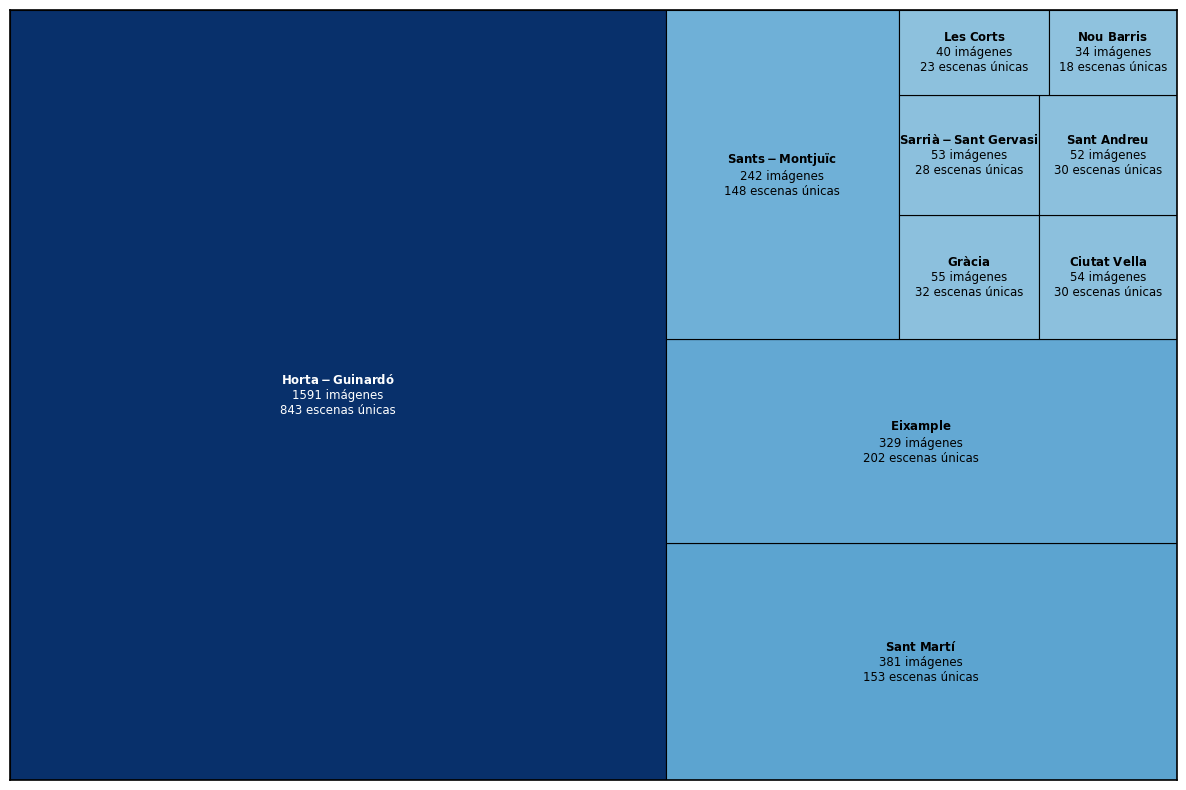

In [11]:
sizes = df_group['n_images']

# Normalitzem i calculem rectangles
normed = squarify.normalize_sizes(sizes, 100, 100)
rects = squarify.squarify(normed, 0, 0, 100, 100)

fig, ax = plt.subplots(figsize=(12, 8))

# Colormap per intensitat d’imatges
cmap = plt.cm.Blues
colors = cmap(0.4 + 0.6 * (sizes / sizes.max()))

for rect, color, (_, row) in zip(rects, colors, df_group.iterrows()):
    x, y, dx, dy = rect['x'], rect['y'], rect['dx'], rect['dy']

    # Dibuixem el rectangle amb contorn negre
    ax.add_patch(plt.Rectangle(
        (x, y), dx, dy,
        facecolor=color,
        edgecolor="black",   # línia negra
        linewidth=0.8
    ))

    

    # Decideix etiqueta segons la mida de la casella
    area = dx * dy

    district = row['nom_districte'].replace(" ", r"\ ")
    
    label = (rf"$\bf{{{district}}}$"
                 f"\n{row['n_images']} imágenes\n"
                 f"{row['n_scenes']} escenas únicas")
    fontsize = 8.5

    text_color = choose_text_color(color)
    ax.text(
    x + dx/2,
    y + dy/2,
    label,
    ha="center", va="center",
    fontsize=fontsize,
    color=text_color
)

# Límits del treemap
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# Amaguem ticks i etiquetes, però mantenim el marc
ax.tick_params(
    left=False, bottom=False,
    labelleft=False, labelbottom=False
)

# 🔲 Vora negra de tota la figura (spines)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor("black")
    spine.set_linewidth(1.2)

#plt.title("Distribución de imágenes y escenas únicas por distritos de la ciudad de Barcelona", fontsize=14)
plt.tight_layout()
plt.show()


In [12]:
metadata_raw_data['geometry'] = [Point(xy) for xy in zip(metadata_raw_data['Longitude'], metadata_raw_data['Latitude'])]

crs = {'init': 'epsg:4326'}

gdf = gpd.GeoDataFrame(metadata_raw_data, crs=crs, geometry = 'geometry')

crs = {'init': 'epsg:4326'}

gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3302 entries, 0 to 3301
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date_Time             3302 non-null   datetime64[ns]
 1   Photo file Name       3302 non-null   object        
 2   Direction             3302 non-null   int64         
 3   Latitude              3302 non-null   float64       
 4   Longitude             3302 non-null   float64       
 5   Position Accuracy     3302 non-null   object        
 6   Altitude              3302 non-null   object        
 7   Datum                 3302 non-null   object        
 8   Capture Mode Details  3302 non-null   object        
 9   Project Name          29 non-null     object        
 10  Photo Description     2424 non-null   object        
 11  Watermark             0 non-null      float64       
 12  Tilt                  3302 non-null   object        
 13  Roll      

/home/joan_ds/Sandbox/UOC/TFM/tfm_uoc/lib/python3.10/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [13]:
df_group = (metadata_raw_data.groupby('nom_districte')
              .agg(
                  n_images=('id', 'count'),
                  n_scenes=('scene_id', 'nunique')
              )
              .reset_index())

df_group = df_group.sort_values('n_images', ascending=False)

In [14]:
municipis = gpd.read_file("/home/joan_ds/Sandbox/UOC/TFM/data/geodata/municipis_catalunya.shp")

municipis.to_crs(4326)

# print(municipis.info())

municipis = municipis[['NAMEUNIT', 'geometry']]

municipis.columns = ['nom_municipi', 'geometry']

#municipis.set_geometry('geometria')

gdf_ = gpd.sjoin(gdf, municipis, predicate='within', how='left')

In [15]:
gdf_.groupby('nom_municipi').size()

nom_municipi
Barcelona                    2826
Esplugues de Llobregat          1
L'Hospitalet de Llobregat      73
Malgrat de Mar                173
Mataró                        133
Pineda de Mar                  25
Sant Adrià de Besòs            30
Santa Coloma de Gramenet       15
Vilassar de Mar                26
dtype: int64

In [16]:
gdf_print = gdf_.groupby('nom_municipi').size()

gdf_print.to_latex('/home/joan_ds/Sandbox/UOC/TFM/data/table01')

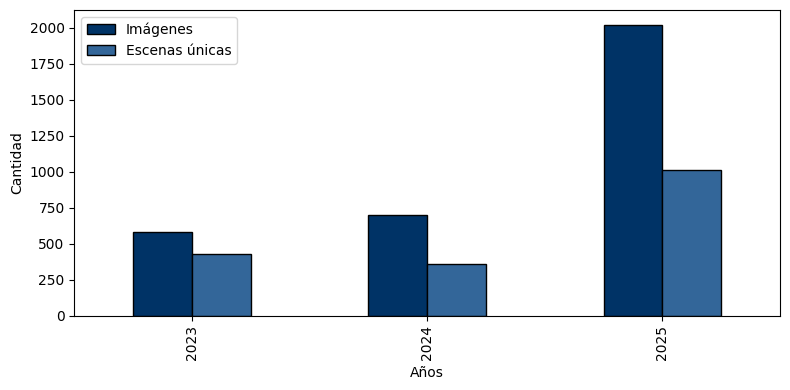

In [17]:
df_year = (
    metadata_raw_data
    .groupby('year')
    .agg(
        n_images=('id', 'count'),
        n_scenes=('scene_id', 'nunique')
    ).sort_index()
)

ax = df_year[['n_images', 'n_scenes']].plot(
    kind='bar', edgecolor='black',
    linewidth=1.0,
    figsize=(8, 4), color=['#003366', '#336699']
)

ax.set_xlabel("Años")
ax.set_ylabel("Cantidad")
ax.legend(["Imágenes", "Escenas únicas"])

plt.tight_layout()
plt.show()



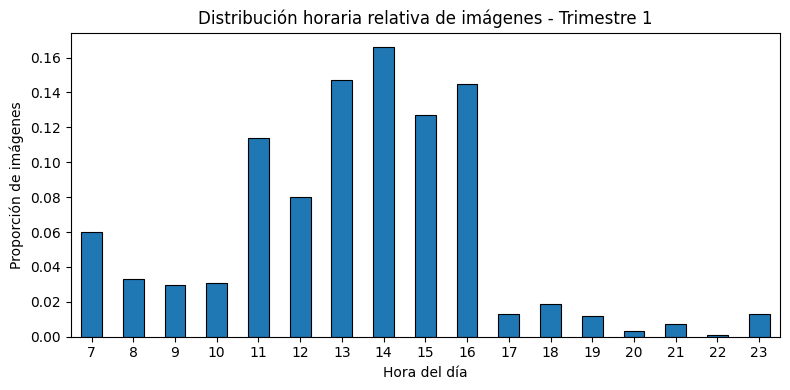

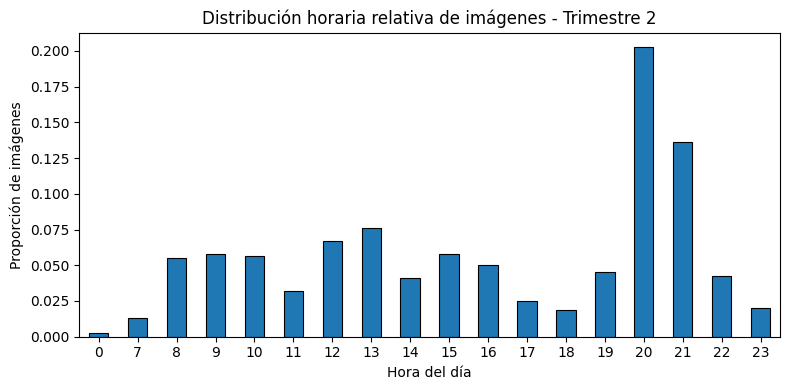

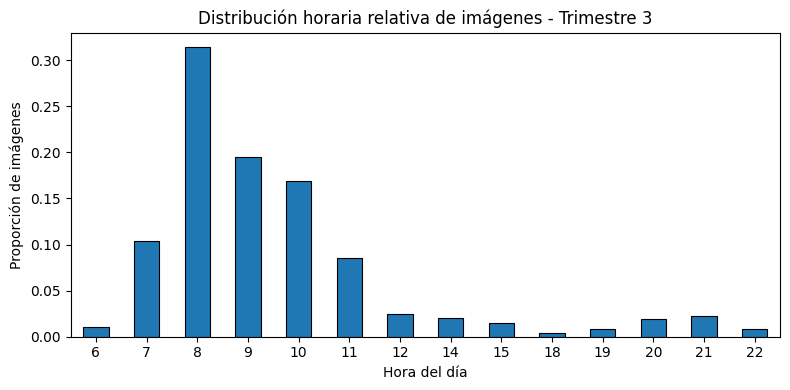

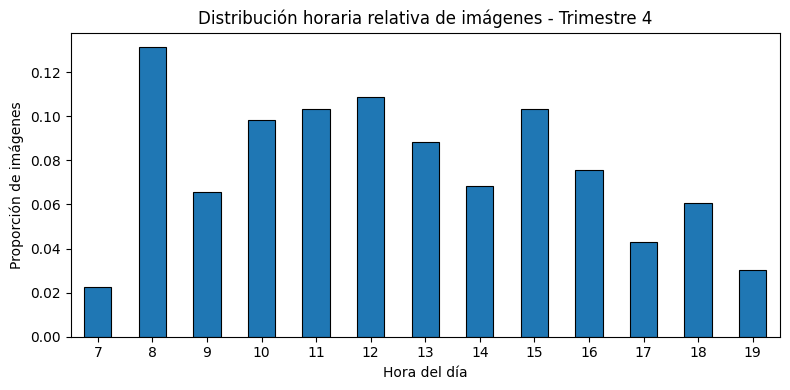

In [18]:
quarters = sorted(metadata_raw_data['quarter'].unique())

for q in quarters:
    df_q = metadata_raw_data[metadata_raw_data['quarter'] == q]
    counts = (
        df_q['hour']
        .value_counts(normalize=True)  # proporció en lloc de recompte absolut
        .sort_index()
    )

    plt.figure(figsize=(8, 4))
    counts.plot(
        kind='bar',
        edgecolor='black',
        linewidth=0.8
    )
    plt.xlabel("Hora del día")
    plt.ylabel("Proporción de imágenes")
    plt.title(f"Distribución horaria relativa de imágenes - Trimestre {q}")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

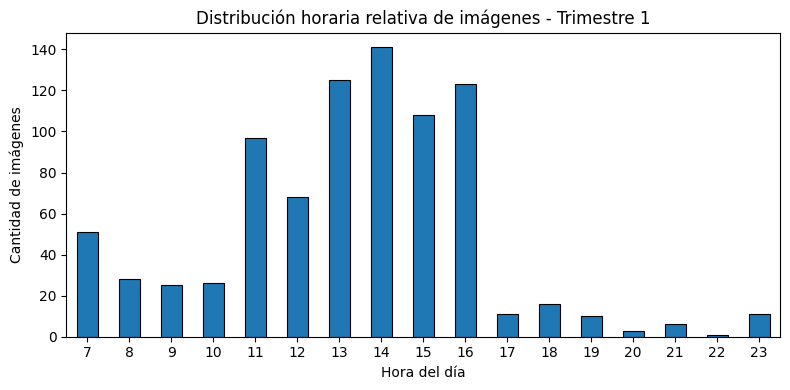

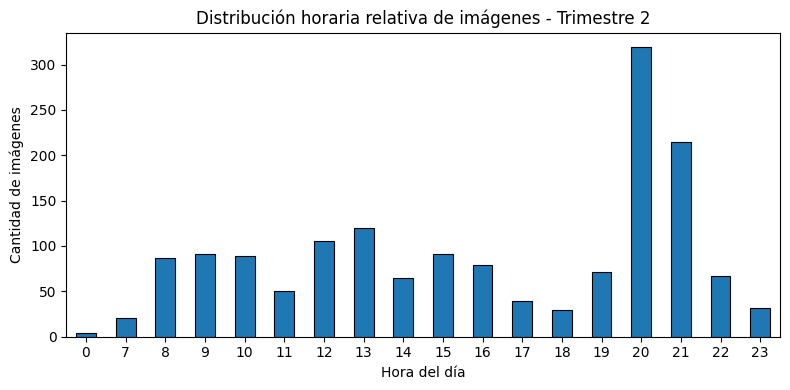

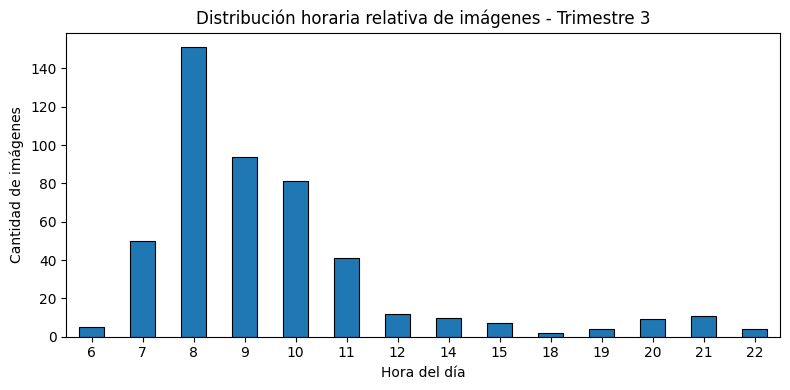

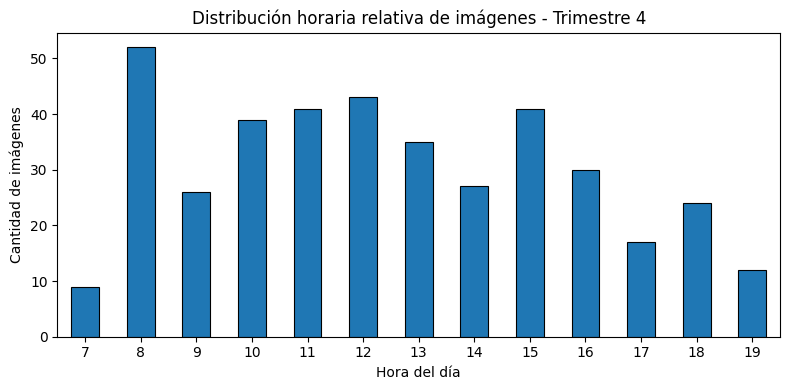

In [19]:
quarters = sorted(metadata_raw_data['quarter'].unique())

for q in quarters:
    df_q = metadata_raw_data[metadata_raw_data['quarter'] == q]

    # Comptar imatges per hora en aquest quarter
    counts = (
        df_q['hour']
        .value_counts()
        .sort_index()      # hores en ordre creixent
    )

    plt.figure(figsize=(8, 4))
    counts.plot(
        kind='bar',

        edgecolor='black',
        linewidth=0.8
    )

    plt.xlabel("Hora del día")
    plt.ylabel("Cantidad de imágenes")
    plt.title(f"Distribución horaria relativa de imágenes - Trimestre {q}")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()




# Figuras y métricas de resolución: apartados 3.1, 3.3 y 3.4

In [20]:
df_group = (metadata_raw_data.groupby('dims_cropped')
              .agg(
                  n_images=('id', 'count'),
              )
              .reset_index())

df_group = df_group.sort_values('n_images', ascending=False)

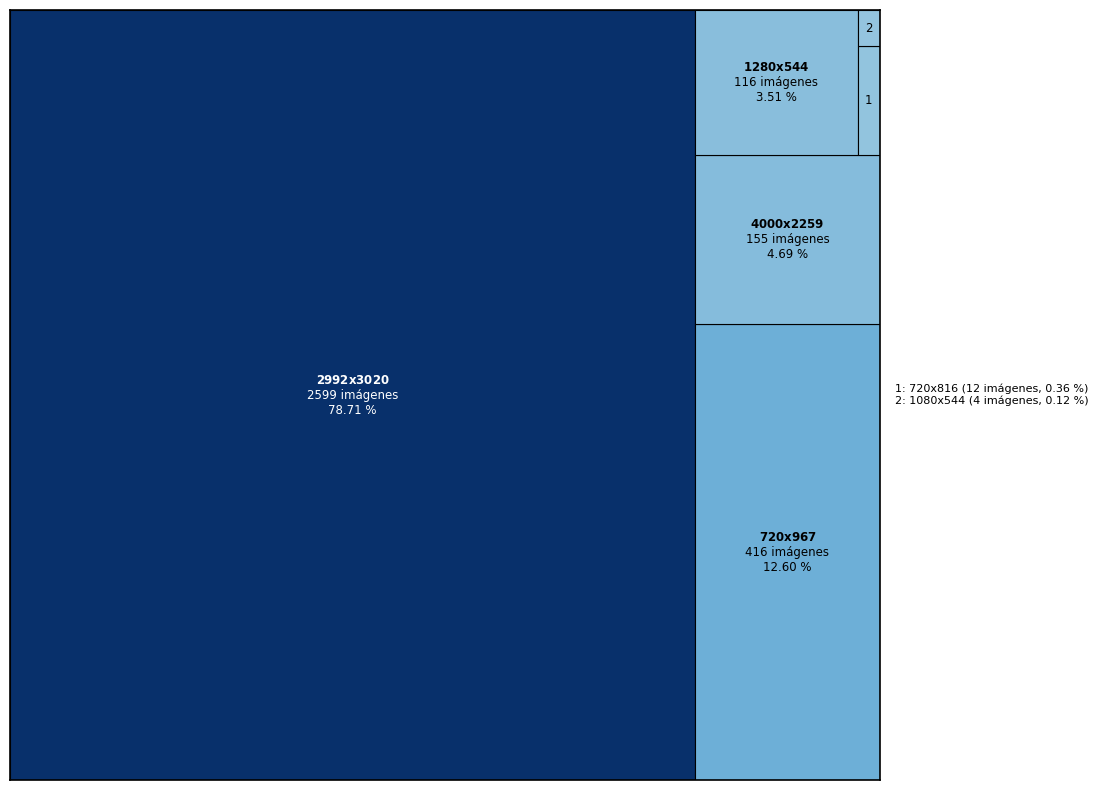

In [21]:

sizes = df_group['n_images']
total = sizes.sum()

# Normalitzem i calculem rectangles
normed = squarify.normalize_sizes(sizes, 100, 100)
rects = squarify.squarify(normed, 0, 0, 100, 100)

fig, ax = plt.subplots(figsize=(12, 8))

# Colormap per intensitat d’imatges
cmap = plt.cm.Blues
colors = cmap(0.4 + 0.6 * (sizes / sizes.max()))

small_legend = []   # (key, district, n_images, prop)
small_key = 1       # clau numèrica per a les <1%

for rect, color, (_, row) in zip(rects, colors, df_group.iterrows()):
    x, y, dx, dy = rect['x'], rect['y'], rect['dx'], rect['dy']

    # Dibuixem el rectangle amb contorn negre
    ax.add_patch(plt.Rectangle(
        (x, y), dx, dy,
        facecolor=color,
        edgecolor="black",   # línia negra
        linewidth=0.8
    ))

    # Proporció respecte al total (0–1)
    prop = row['n_images'] / total

    district = row['dims_cropped'].replace(" ", r"\ ")

    # Si la proporció és <1%, fem servir una clau numèrica
    if prop < 0.01:
        label = str(small_key)
        small_legend.append(
            (small_key, row['dims_cropped'], row['n_images'], prop)
        )
        small_key += 1
    else:
        # Etiqueta normal amb nom en negreta + nº imatges
        label = (
            rf"$\bf{{{district}}}$"
            f"\n{row['n_images']} imágenes\n{prop*100:.2f} %"
        )

    fontsize = 8.5
    text_color = choose_text_color(color)

    ax.text(
        x + dx/2,
        y + dy/2,
        label,
        ha="center", va="center",
        fontsize=fontsize,
        color=text_color
    )

# Límits del treemap
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# Amaguem ticks i etiquetes, però mantenim el marc
ax.tick_params(
    left=False, bottom=False,
    labelleft=False, labelbottom=False
)

# 🔲 Vora negra de tota la figura (spines)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor("black")
    spine.set_linewidth(1.2)

# Reservem espai a la dreta per a la llegenda
plt.tight_layout(rect=[0, 0, 0.75, 1])

# Llegenda per a les classes <1%
if small_legend:
    legend_lines = [
        f"{key}: {name} ({n_imgs} imágenes, {prop*100:.2f} %)"
        for key, name, n_imgs, prop in small_legend
    ]
    legend_text = "\n".join(legend_lines)

    fig.text(
        0.75, 0.5,           # a la dreta del treemap
        legend_text,
        va='center',
        ha='left',
        fontsize=8
    )

# plt.title("Distribución de imágenes y escenas únicas por distritos de la ciudad de Barcelona", fontsize=14)
plt.show()

In [22]:
ann_gt_data['id'] = ann_gt_data['file_name'].str.replace(".jpg", "")
# print(ann_gt_data.id[0])
resolution_3_3_df = pd.merge(ann_gt_data, metadata_raw_data, on='id')
resolution_3_3_df = resolution_3_3_df[['id', 'dims_cropped']]
resolution_3_3_df.head(2)

,id,dims_cropped
0,2023-06-20-15-51-32,1080x544
1,2023-06-20-16-58-53,720x816


In [23]:
df_group = (resolution_3_3_df.groupby('dims_cropped')
              .agg(
                  n_images=('id', 'count'),
              )
              .reset_index())

df_group = df_group.sort_values('n_images', ascending=False)

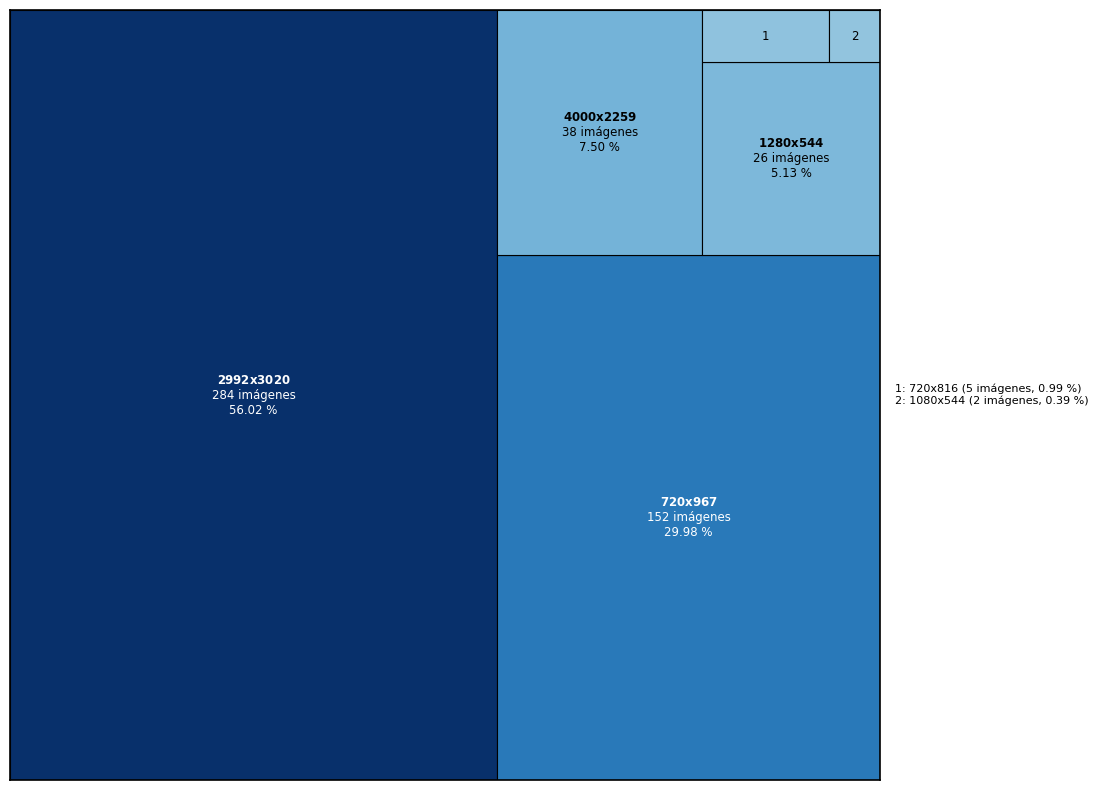

In [24]:
sizes = df_group['n_images']
total = sizes.sum()

# Normalitzem i calculem rectangles
normed = squarify.normalize_sizes(sizes, 100, 100)
rects = squarify.squarify(normed, 0, 0, 100, 100)

fig, ax = plt.subplots(figsize=(12, 8))

# Colormap per intensitat d’imatges
cmap = plt.cm.Blues
colors = cmap(0.4 + 0.6 * (sizes / sizes.max()))

small_legend = []   # (key, district, n_images, prop)
small_key = 1       # clau numèrica per a les <1%

for rect, color, (_, row) in zip(rects, colors, df_group.iterrows()):
    x, y, dx, dy = rect['x'], rect['y'], rect['dx'], rect['dy']

    # Dibuixem el rectangle amb contorn negre
    ax.add_patch(plt.Rectangle(
        (x, y), dx, dy,
        facecolor=color,
        edgecolor="black",   # línia negra
        linewidth=0.8
    ))

    # Proporció respecte al total (0–1)
    prop = row['n_images'] / total

    district = row['dims_cropped'].replace(" ", r"\ ")

    # Si la proporció és <1%, fem servir una clau numèrica
    if prop < 0.01:
        label = str(small_key)
        small_legend.append(
            (small_key, row['dims_cropped'], row['n_images'], prop)
        )
        small_key += 1
    else:
        # Etiqueta normal amb nom en negreta + nº imatges
        label = (
            rf"$\bf{{{district}}}$"
            f"\n{row['n_images']} imágenes\n{prop*100:.2f} %"
        )

    fontsize = 8.5
    text_color = choose_text_color(color)

    ax.text(
        x + dx/2,
        y + dy/2,
        label,
        ha="center", va="center",
        fontsize=fontsize,
        color=text_color
    )

# Límits del treemap
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# Amaguem ticks i etiquetes, però mantenim el marc
ax.tick_params(
    left=False, bottom=False,
    labelleft=False, labelbottom=False
)

# 🔲 Vora negra de tota la figura (spines)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor("black")
    spine.set_linewidth(1.2)

# Reservem espai a la dreta per a la llegenda
plt.tight_layout(rect=[0, 0, 0.75, 1])

# Llegenda per a les classes <1%
if small_legend:
    legend_lines = [
        f"{key}: {name} ({n_imgs} imágenes, {prop*100:.2f} %)"
        for key, name, n_imgs, prop in small_legend
    ]
    legend_text = "\n".join(legend_lines)

    fig.text(
        0.75, 0.5,           # a la dreta del treemap
        legend_text,
        va='center',
        ha='left',
        fontsize=8
    )

# plt.title("Distribución de imágenes y escenas únicas por distritos de la ciudad de Barcelona", fontsize=14)
plt.show()

In [25]:
training_files = train_files + val_files
training_files_names = [f.replace('.png', '') for f in training_files]
len(training_files_names)

430

In [26]:
mask_training = resolution_3_3_df.id.isin(training_files_names)
resolution_4_3_training_df = resolution_3_3_df[mask_training]

In [27]:
df_group = (resolution_4_3_training_df.groupby('dims_cropped')
              .agg(
                  n_images=('id', 'count'),
              )
              .reset_index())

df_group = df_group.sort_values('n_images', ascending=False)

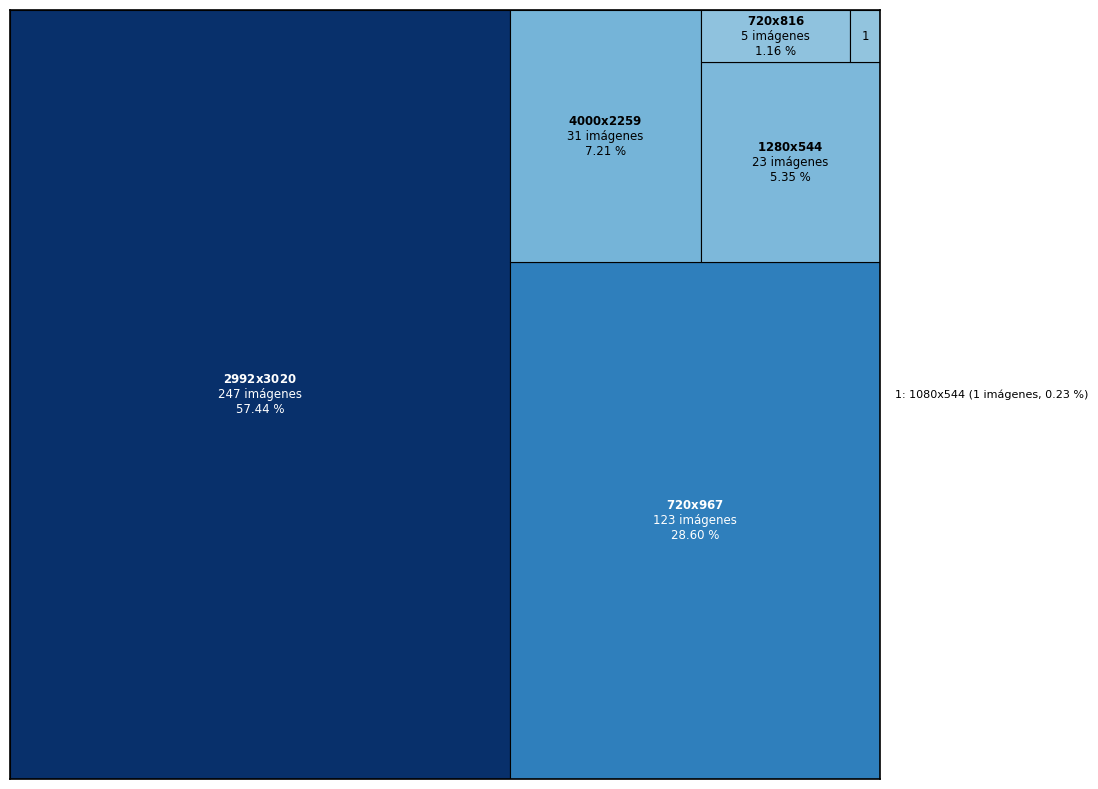

In [28]:
sizes = df_group['n_images']
total = sizes.sum()

# Normalitzem i calculem rectangles
normed = squarify.normalize_sizes(sizes, 100, 100)
rects = squarify.squarify(normed, 0, 0, 100, 100)

fig, ax = plt.subplots(figsize=(12, 8))

# Colormap per intensitat d’imatges
cmap = plt.cm.Blues
colors = cmap(0.4 + 0.6 * (sizes / sizes.max()))

small_legend = []   # (key, district, n_images, prop)
small_key = 1       # clau numèrica per a les <1%

for rect, color, (_, row) in zip(rects, colors, df_group.iterrows()):
    x, y, dx, dy = rect['x'], rect['y'], rect['dx'], rect['dy']

    # Dibuixem el rectangle amb contorn negre
    ax.add_patch(plt.Rectangle(
        (x, y), dx, dy,
        facecolor=color,
        edgecolor="black",   # línia negra
        linewidth=0.8
    ))

    # Proporció respecte al total (0–1)
    prop = row['n_images'] / total

    district = row['dims_cropped'].replace(" ", r"\ ")

    # Si la proporció és <1%, fem servir una clau numèrica
    if prop < 0.01:
        label = str(small_key)
        small_legend.append(
            (small_key, row['dims_cropped'], row['n_images'], prop)
        )
        small_key += 1
    else:
        # Etiqueta normal amb nom en negreta + nº imatges
        label = (
            rf"$\bf{{{district}}}$"
            f"\n{row['n_images']} imágenes\n{prop*100:.2f} %"
        )

    fontsize = 8.5
    text_color = choose_text_color(color)

    ax.text(
        x + dx/2,
        y + dy/2,
        label,
        ha="center", va="center",
        fontsize=fontsize,
        color=text_color
    )

# Límits del treemap
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# Amaguem ticks i etiquetes, però mantenim el marc
ax.tick_params(
    left=False, bottom=False,
    labelleft=False, labelbottom=False
)

# 🔲 Vora negra de tota la figura (spines)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor("black")
    spine.set_linewidth(1.2)

# Reservem espai a la dreta per a la llegenda
plt.tight_layout(rect=[0, 0, 0.75, 1])

# Llegenda per a les classes <1%
if small_legend:
    legend_lines = [
        f"{key}: {name} ({n_imgs} imágenes, {prop*100:.2f} %)"
        for key, name, n_imgs, prop in small_legend
    ]
    legend_text = "\n".join(legend_lines)

    fig.text(
        0.75, 0.5,           # a la dreta del treemap
        legend_text,
        va='center',
        ha='left',
        fontsize=8
    )

# plt.title("Distribución de imágenes y escenas únicas por distritos de la ciudad de Barcelona", fontsize=14)
plt.show()

In [29]:
test_files_names = [f.replace('.png', '') for f in test_files]
len(test_files_names)

77

In [30]:
mask_test = resolution_3_3_df.id.isin(test_files_names)
resolution_4_3_test_df = resolution_3_3_df[mask_test]

In [31]:
df_group = (resolution_4_3_test_df.groupby('dims_cropped')
              .agg(
                  n_images=('id', 'count'),
              )
              .reset_index())

df_group = df_group.sort_values('n_images', ascending=False)

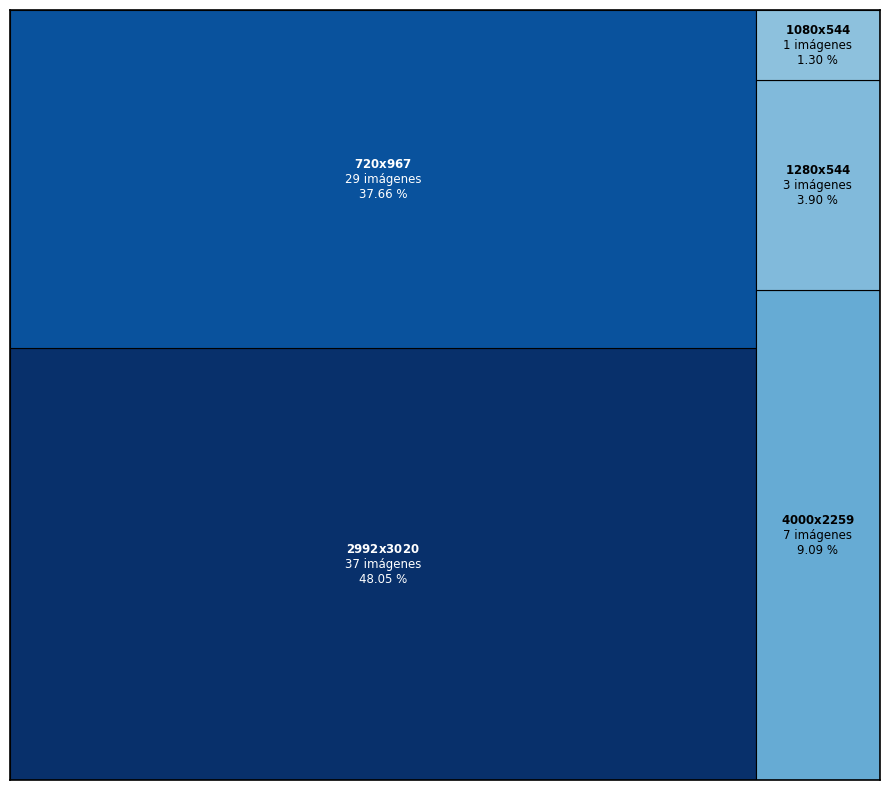

In [32]:
sizes = df_group['n_images']
total = sizes.sum()

# Normalitzem i calculem rectangles
normed = squarify.normalize_sizes(sizes, 100, 100)
rects = squarify.squarify(normed, 0, 0, 100, 100)

fig, ax = plt.subplots(figsize=(12, 8))

# Colormap per intensitat d’imatges
cmap = plt.cm.Blues
colors = cmap(0.4 + 0.6 * (sizes / sizes.max()))

small_legend = []   # (key, district, n_images, prop)
small_key = 1       # clau numèrica per a les <1%

for rect, color, (_, row) in zip(rects, colors, df_group.iterrows()):
    x, y, dx, dy = rect['x'], rect['y'], rect['dx'], rect['dy']

    # Dibuixem el rectangle amb contorn negre
    ax.add_patch(plt.Rectangle(
        (x, y), dx, dy,
        facecolor=color,
        edgecolor="black",   # línia negra
        linewidth=0.8
    ))

    # Proporció respecte al total (0–1)
    prop = row['n_images'] / total

    district = row['dims_cropped'].replace(" ", r"\ ")

    # Si la proporció és <1%, fem servir una clau numèrica
    if prop < 0.01:
        label = str(small_key)
        small_legend.append(
            (small_key, row['dims_cropped'], row['n_images'], prop)
        )
        small_key += 1
    else:
        # Etiqueta normal amb nom en negreta + nº imatges
        label = (
            rf"$\bf{{{district}}}$"
            f"\n{row['n_images']} imágenes\n{prop*100:.2f} %"
        )

    fontsize = 8.5
    text_color = choose_text_color(color)

    ax.text(
        x + dx/2,
        y + dy/2,
        label,
        ha="center", va="center",
        fontsize=fontsize,
        color=text_color
    )

# Límits del treemap
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# Amaguem ticks i etiquetes, però mantenim el marc
ax.tick_params(
    left=False, bottom=False,
    labelleft=False, labelbottom=False
)

# 🔲 Vora negra de tota la figura (spines)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor("black")
    spine.set_linewidth(1.2)

# Reservem espai a la dreta per a la llegenda
plt.tight_layout(rect=[0, 0, 0.75, 1])

# Llegenda per a les classes <1%
if small_legend:
    legend_lines = [
        f"{key}: {name} ({n_imgs} imágenes, {prop*100:.2f} %)"
        for key, name, n_imgs, prop in small_legend
    ]
    legend_text = "\n".join(legend_lines)

    fig.text(
        0.80, 0.5,           # a la dreta del treemap
        legend_text,
        va='center',
        ha='left',
        fontsize=8
    )

# plt.title("Distribución de imágenes y escenas únicas por distritos de la ciudad de Barcelona", fontsize=14)
plt.show()

# Figuras y métricas de clases anotadas: apartados 3.3 y 3.4

In [33]:
counter = Counter()

for file in os.listdir(json_path):
    if file.endswith(".json"):
        with open(os.path.join(json_path, file), "r") as f:
            data = json.load(f)
            for shape in data.get("shapes", []):
                label = shape.get("label", None)
                if label:
                    counter[label] += 1

# Resultat
print(counter)

Counter({'0': 1070, '255': 832, '6': 690, '9': 604, '3': 503, '5': 407, '2': 356, '7': 322, '8': 279, '4': 121, '1': 61})


In [34]:
df_labels = pd.DataFrame.from_dict(counter, orient='index', columns=['count'])
df_labels = df_labels.sort_values('count', ascending=False)
print(df_labels)

     count
0     1070
255    832
6      690
9      604
3      503
5      407
2      356
7      322
8      279
4      121
1       61


In [35]:
labels_new_index = ['sidewalk_tiles', 'ignore', 'access_cover', 'street_furniture', 'curb_edge', 'gutter', 
                    'roadway', 'tree_pit', 'vegetation', 'drainage_inlet', 'sidewalk_asphalt']

df_labels.index = labels_new_index

In [36]:
sizes = df_labels['count']
total = sizes.sum()
sizes

sidewalk_tiles      1070
ignore               832
access_cover         690
street_furniture     604
curb_edge            503
gutter               407
roadway              356
tree_pit             322
vegetation           279
drainage_inlet       121
sidewalk_asphalt      61
Name: count, dtype: int64

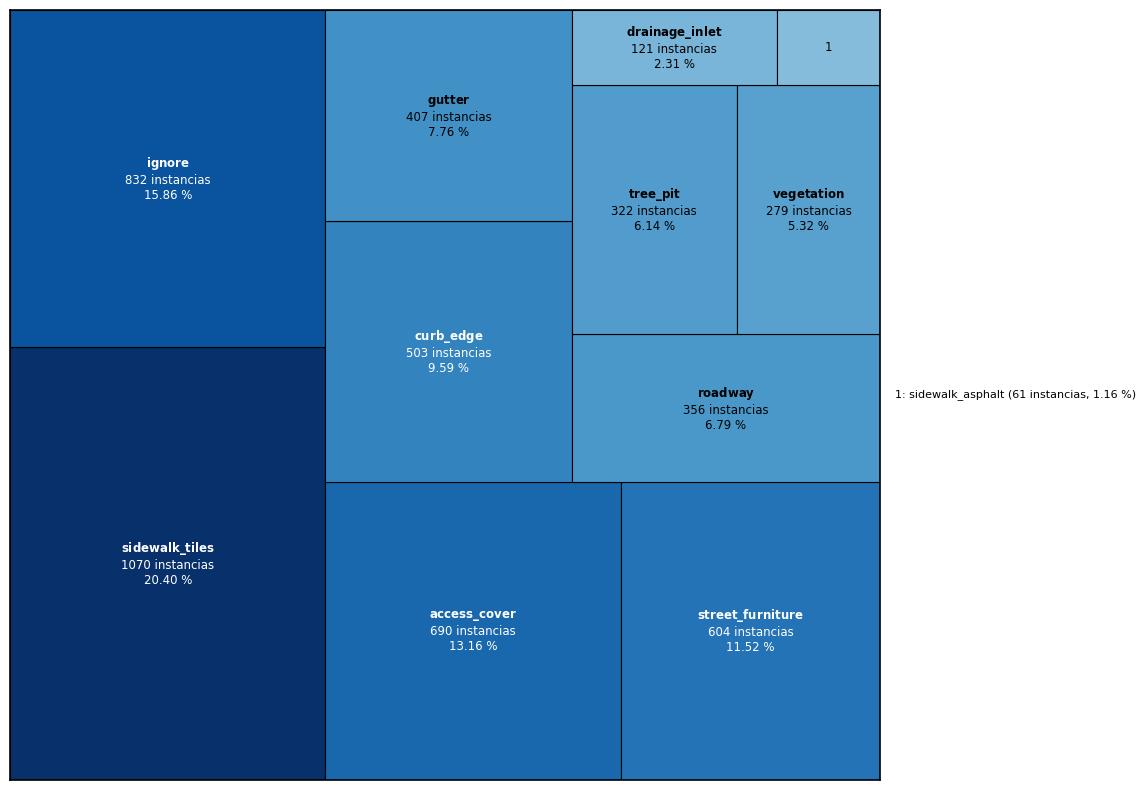

In [37]:
df_labels = pd.DataFrame.from_dict(counter, orient='index', columns=['count'])
df_labels = df_labels.sort_values('count', ascending=False)

labels_new_index = [
    'sidewalk_tiles', 'ignore', 'access_cover', 'street_furniture', 'curb_edge', 'gutter',
    'roadway', 'tree_pit', 'vegetation', 'drainage_inlet', 'sidewalk_asphalt'
]
df_labels.index = labels_new_index

sizes = df_labels['count']
total = sizes.sum()

# Normalitzem i calculem rectangles
normed = squarify.normalize_sizes(sizes, 100, 100)
rects = squarify.squarify(normed, 0, 0, 100, 100)

fig, ax = plt.subplots(figsize=(12, 8))

# Colormap per intensitat
cmap = plt.cm.Blues
colors = cmap(0.4 + 0.6 * (sizes / sizes.max()))

small_legend = []   # (key, class_name, count, prop)
small_key = 1       # clau numèrica per a les <1%

for rect, color, (cls_name, row) in zip(rects, colors, df_labels.iterrows()):
    x, y, dx, dy = rect['x'], rect['y'], rect['dx'], rect['dy']

    # Rectangle amb contorn
    ax.add_patch(plt.Rectangle(
        (x, y), dx, dy,
        facecolor=color,
        edgecolor="black",
        linewidth=0.8
    ))

    # Proporció respecte al total
    prop = row['count'] / total

    # Nom de la classe per a mathtext: escapem underscores
    cls_math = cls_name.replace("_", r"\_")

    # Si la proporció és <1%, fem servir una clau numèrica
    if prop < 0.015:
        label = str(small_key)
        small_legend.append(
            (small_key, cls_name, row['count'], prop)
        )
        small_key += 1
    else:
        # Etiqueta normal amb nom en negreta + count + %
        label = (
            rf"$\bf{{{cls_math}}}$"
            f"\n{row['count']} instancias\n{prop*100:.2f} %"
        )

    fontsize = 8.5
    text_color = choose_text_color(color)

    ax.text(
        x + dx/2,
        y + dy/2,
        label,
        ha="center", va="center",
        fontsize=fontsize,
        color=text_color
    )

# Límits del treemap
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# Amaguem ticks, però mantenim el marc
ax.tick_params(
    left=False, bottom=False,
    labelleft=False, labelbottom=False
)

# Vora negra de tota la figura
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor("black")
    spine.set_linewidth(1.2)

# Reservem espai a la dreta per a la llegenda
plt.tight_layout(rect=[0, 0, 0.75, 1])

# Llegenda per a les classes <1 %
if small_legend:
    legend_lines = [
        f"{key}: {name} ({n} instancias, {prop*100:.2f} %)"
        for key, name, n, prop in small_legend
    ]
    legend_text = "\n".join(legend_lines)

    fig.text(
        0.75, 0.5,        # clarament a la dreta del treemap
        legend_text,
        va='center',
        ha='left',
        fontsize=8
    )

plt.show()

In [38]:
paths_masks = [{'name': 'train', 'path': mypaths[0]}, {'name': 'val', 'path': mypaths[1]}, {'name': 'test', 'path': mypaths[2]}]

area_counter = Counter()
area_counters = []

for path_masks in paths_masks:
    name = path_masks['name']
    path_ = path_masks['path']
    for file in os.listdir(path_):
        if file.endswith(".png"):
            mask_path = os.path.join(path_, file)
            mask = np.array(Image.open(mask_path))

        # Comptem píxels per valor de la màscara
            values, counts = np.unique(mask, return_counts=True)

            for v, c in zip(values, counts):
                cls_name = INDEX_TO_CLASS.get(int(v), f"unknown_{v}")
            # si vols ignorar background:
                area_counter[cls_name] += int(c)
    column_label = f"{name}_n_pixels"
    df_area = (pd.DataFrame
           .from_dict(area_counter, orient="index", columns=[column_label])
           .sort_values(column_label, ascending=False))
    area_counters.append(df_area)
    print(area_counter)  # píxels totals per classe

Counter({'sidewalk_tiles': 236128653, 'unknown_255': 96663895, 'roadway': 49659810, 'curb_edge': 11941458, 'vegetation': 7445897, 'tree_pit': 6988392, 'gutter': 5512789, 'street_furniture': 4287327, 'sidewalk_asphalt': 1128270, 'drainage_inlet': 627509, 'access_cover': 61520})
Counter({'sidewalk_tiles': 468766679, 'unknown_255': 221217494, 'roadway': 109578786, 'curb_edge': 27328169, 'tree_pit': 17288189, 'vegetation': 15051544, 'gutter': 14120580, 'street_furniture': 10117493, 'sidewalk_asphalt': 4576722, 'access_cover': 1620718, 'drainage_inlet': 675226})
Counter({'sidewalk_tiles': 1591382026, 'unknown_255': 729323051, 'roadway': 395555589, 'curb_edge': 102797224, 'gutter': 59266012, 'tree_pit': 48014716, 'vegetation': 43756667, 'street_furniture': 30515130, 'sidewalk_asphalt': 16217918, 'access_cover': 13683714, 'drainage_inlet': 7079953})


In [39]:
df_area1 = area_counters[0].join(area_counters[1])
df_area_def = df_area1.join(area_counters[2])

for col in df_area_def.columns:
    new_col_label = col.split("_")[0] + "_prop"
    total = sum(df_area_def[col])
    df_area_def[new_col_label] = df_area_def[col] / total

df_area_def['training_n'] = df_area_def.train_n_pixels + df_area_def.val_n_pixels
df_area_def['training_prop'] = df_area_def.training_n / sum(df_area_def.training_n)

df_area_def = df_area_def.round(5)
df_area_print = df_area_def[['train_prop', 'val_prop', 'training_prop', 'test_prop']]

new_index = ['sidewalk_tiles', 'ignore (255)', 'roadway', 'curb_edge', 'vegetation',
       'tree_pit', 'gutter', 'street_furniture', 'sidewalk_asphalt',
       'drainage_inlet', 'access_cover']

df_area_print.index = new_index

df_area_print

,train_prop,val_prop,training_prop,test_prop
sidewalk_tiles,0.56162,0.52650,0.53776,0.52390
ignore (255),0.22991,0.24846,0.24251,0.24010
roadway,0.11811,0.12307,0.12148,0.13022
curb_edge,0.02840,0.03069,0.02996,0.03384
vegetation,0.01771,0.01691,0.01716,0.01441
tree_pit,0.01662,0.01942,0.01852,0.01581
gutter,0.01311,0.01586,0.01498,0.01951
street_furniture,0.01020,0.01136,0.01099,0.01005
sidewalk_asphalt,0.00268,0.00514,0.00435,0.00534
drainage_inlet,0.00149,0.00076,0.00099,0.00233


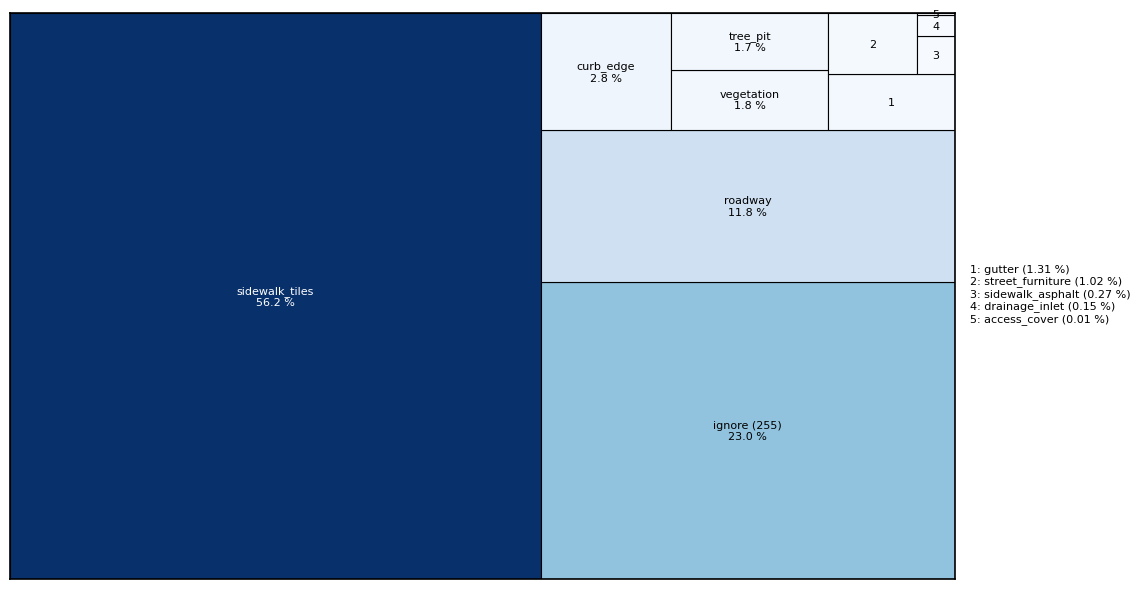

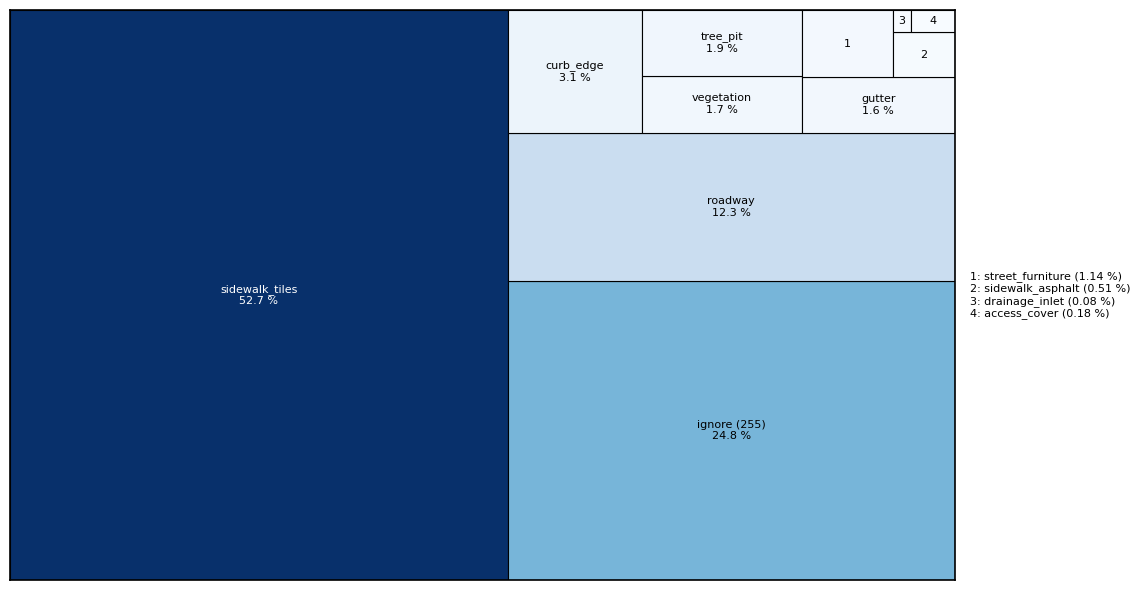

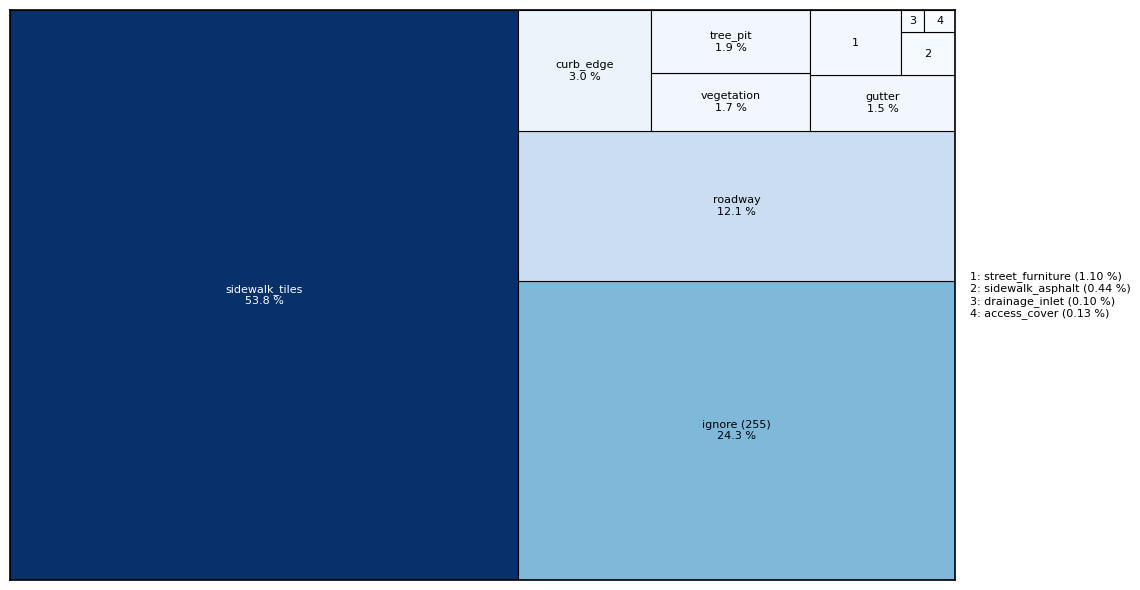

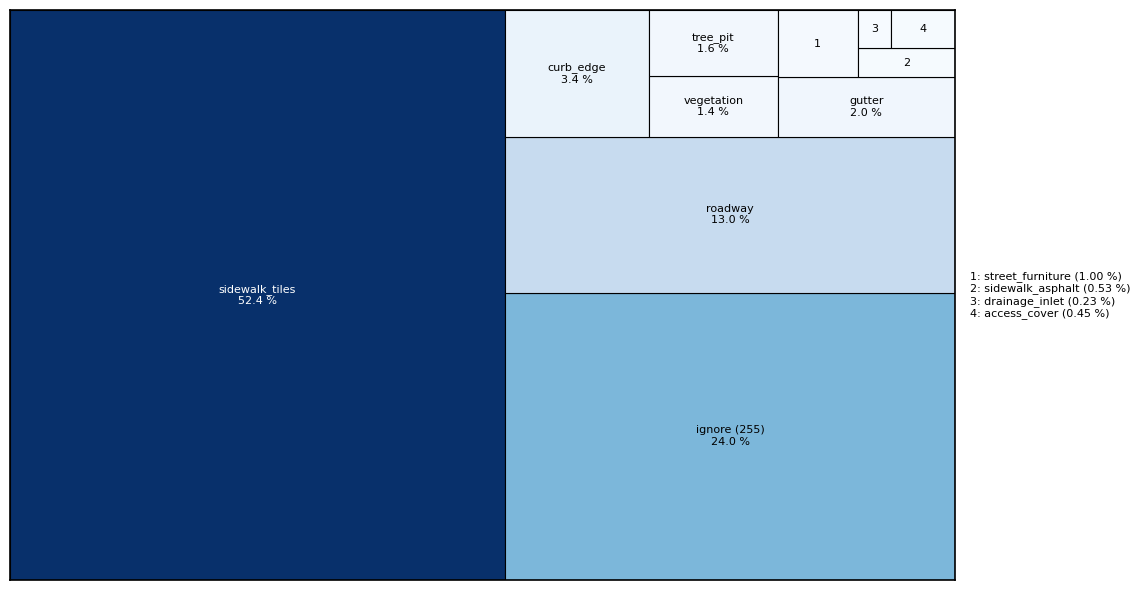

In [40]:
for col in df_area_print.columns:

    s = df_area_print[col].dropna()

    # Opcional: eliminar classes amb proporció 0
    s = s[s > 0]

    if s.empty:
        continue  # res a dibuixar per aquesta columna

    # Si per algun motiu no sumen exactament 1, normalitzem:
    total = s.sum()
    proportions = s / total          # proporció real de cada classe (0–1)
    sizes = s.values                 # mides per treemap (podem usar s directament)

    class_names = s.index.tolist()

    # Normalitzar i calcular rectangles del treemap
    normed = squarify.normalize_sizes(sizes, 100, 100)
    rects = squarify.squarify(normed, 0, 0, 100, 100)

    fig, ax = plt.subplots(figsize=(13, 6))

    cmap = plt.cm.Blues
    colors = cmap(sizes / sizes.max())

    small_legend = []   # per guardar (clau, classe, proporció) de les <1%
    small_key = 1       # clau numèrica per les classes petites

    for rect, color, cls_name, prop in zip(rects, colors, class_names, proportions.values):
        x, y, dx, dy = rect['x'], rect['y'], rect['dx'], rect['dy']

        # Rectangle amb vora negra
        ax.add_patch(plt.Rectangle(
            (x, y), dx, dy,
            facecolor=color,
            edgecolor="black",
            linewidth=0.8
        ))

        # Triem color del text segons lluminositat del fons
        text_color = choose_text_color(color)

        # Si la proporció és <1%, substituïm etiqueta per una clau numèrica
        if prop < 0.014:   # ~1.4% si proportions són 0–1
            label = str(small_key)
            # Guardem la info completa per la llegenda lateral
            small_legend.append((small_key, cls_name, prop))
            small_key += 1
        else:
            # Etiqueta normal amb nom + percentatge
            label = f"{cls_name}\n{prop*100:.1f} %"

        ax.text(
            x + dx/2,
            y + dy/2,
            label,
            ha="center", va="center",
            fontsize=8,
            color=text_color
        )

    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)

    # ❌ No fem ax.set_axis_off(), perquè això amaga també les spines
    # Amaguem només ticks i etiquetes de ticks:
    ax.set_xticks([])
    ax.set_yticks([])

    # 🔲 Activem i dibuixem les 4 vores (inclosa la dreta)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor("black")
        spine.set_linewidth(1.2)

    # plt.title(f"Proporció per classe – {col}", fontsize=14)

    # Reservem espai a la dreta per la llegenda
    plt.tight_layout(rect=[0, 0, 0.75, 1])

    # Si hi ha classes petites (<1%), afegim una llegenda a la dreta
    if small_legend:
        legend_lines = [
            f"{key}: {name} ({prop*100:.2f} %)"
            for key, name, prop in small_legend
        ]
        legend_text = "\n".join(legend_lines)

        # Coordenades en espai de figura, clarament a la dreta del treemap
        fig.text(
            0.75, 0.5,           # x > 0.75 per posar-la fora del treemap
            legend_text,
            va='center',
            ha='left',
            fontsize=8
        )

    plt.show()

# Métricas mIoU y IoU-clase del conjunto de test: apartado 4.3

Ver notebook *analysis_test_TFM.ipynb*

# Figuras y métricas del experimento de preanotación: apartado 4.2

In [41]:
preann_SAM_data.columns

Index(['file_name', 'time_no_SAM', 'time_pred', 'time_test', 'n_masks_gt',
       'n_masks_pred', 'n_masks_edited', 'n_masks_added', 'n_masks_deleted',
       'view', 'night', 'dry', 'shadows', 'sidewalk_pavement_anomaly',
       'humans', 'mIoU', 'stratum'],
      dtype='object')

In [55]:
ann_gt_data.time_no_SAM.mean()

4.668639053254438

In [56]:
ann_gt_data.time_no_SAM.mode()

0    2
Name: time_no_SAM, dtype: int64

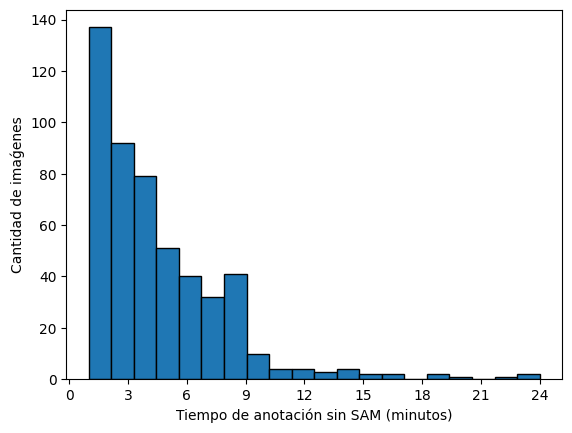

In [57]:
ax = ann_gt_data.time_no_SAM.hist(bins=20, grid=False,edgecolor='black',
    linewidth=1.0)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel("Tiempo de anotación sin SAM (minutos)")
plt.ylabel("Cantidad de imaǵenes")
plt.savefig("/home/joan_ds/Sandbox/UOC/Cap4_FigAnnTime.png")

plt.show()


0.25    2.0
0.50    4.0
0.75    6.0
Name: time_no_SAM, dtype: float64


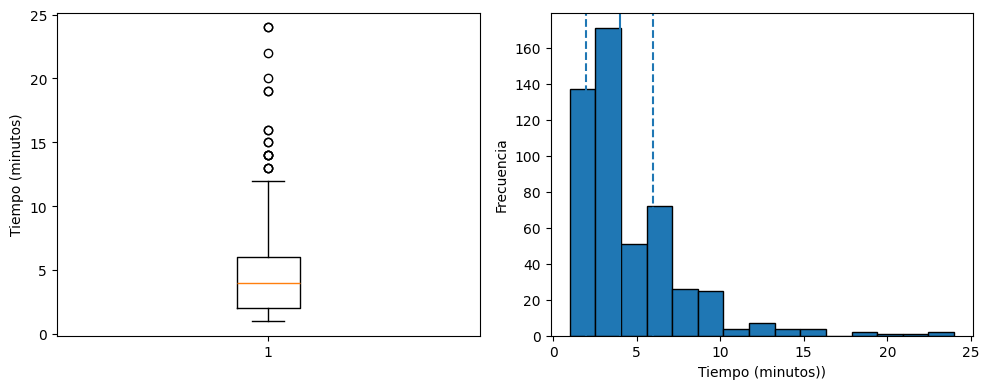

In [66]:
q = ann_gt_data['time_no_SAM'].quantile([0.25, 0.5, 0.75])
print(q)

col = 'time_no_SAM'

# Recalculem quartils per tenir-los a mà
q1, q2, q3 = ann_gt_data[col].quantile([0.25, 0.5, 0.75])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# --- Boxplot ---
axes[0].boxplot(ann_gt_data[col].dropna(), vert=True)
axes[0].set_ylabel("Tiempo (minutos)")
axes[1].set_xlabel("Anotación GT realizada manualmente")

# --- Histograma amb línies de quartil ---
axes[1].hist(ann_gt_data[col].dropna(), bins=15, edgecolor='black',
    linewidth=1.0)
axes[1].set_xlabel("Tiempo (minutos))")
axes[1].set_ylabel("Frecuencia")

for qv, ls in zip([q1, q2, q3], ['--', '-', '--']):
    axes[1].axvline(qv, linestyle=ls)

plt.tight_layout()
plt.show()

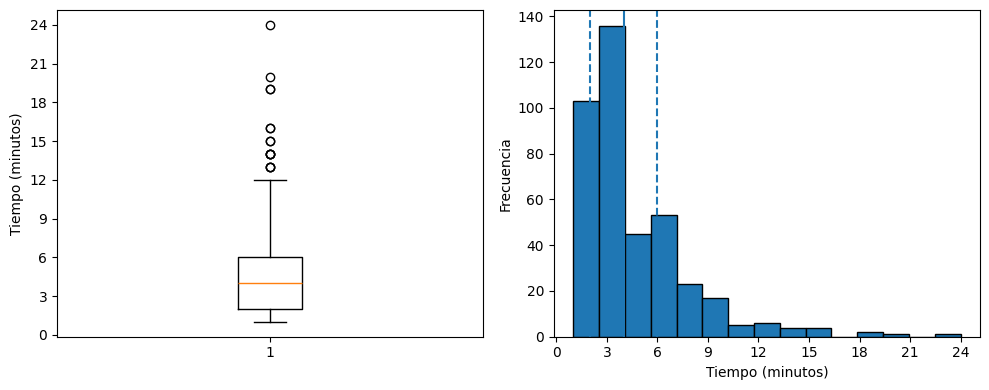

In [88]:
col = "time_no_SAM"
data = preann_SAM_data[col].dropna()

# Quartils (assegura't d'haver-ho calculat abans si vols usar-los)
q1, q2, q3 = data.quantile([0.25, 0.5, 0.75])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# --- Boxplot ---
axes[0].boxplot(data, vert=True)
axes[0].set_ylabel("Tiempo (minutos)")
#axes[0].set_xlabel("Preanotación con SAM")

# Forçar ticks de l’eix Y a enters
axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))

# --- Histograma amb línies de quartil ---
axes[1].hist(data, bins=15, edgecolor='black', linewidth=1.0)
axes[1].set_xlabel("Tiempo (minutos)")
axes[1].set_ylabel("Frecuencia")
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))

for qv, ls in zip([q1, q2, q3], ['--', '-', '--']):
    axes[1].axvline(qv, linestyle=ls)

plt.tight_layout()
plt.show()

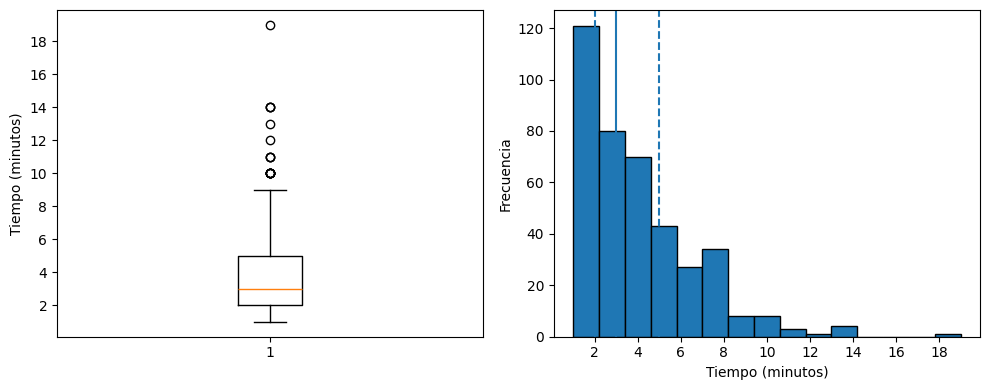

In [87]:
col = "time_test"
data = preann_SAM_data[col].dropna()

# Quartils (assegura't d'haver-ho calculat abans si vols usar-los)
q1, q2, q3 = data.quantile([0.25, 0.5, 0.75])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# --- Boxplot ---
axes[0].boxplot(data, vert=True)
axes[0].set_ylabel("Tiempo (minutos)")
#axes[0].set_xlabel("Preanotación con SAM")

# Forçar ticks de l’eix Y a enters
axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))

# --- Histograma amb línies de quartil ---
axes[1].hist(data, bins=15, edgecolor='black', linewidth=1.0)
axes[1].set_xlabel("Tiempo (minutos)")
axes[1].set_ylabel("Frecuencia")
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))

for qv, ls in zip([q1, q2, q3], ['--', '-', '--']):
    axes[1].axvline(qv, linestyle=ls)

plt.tight_layout()
plt.show()

In [81]:
print(preann_SAM_data.time_test.mode())
preann_SAM_data.time_test.mean()

0    3
Name: time_test, dtype: int64


4.06

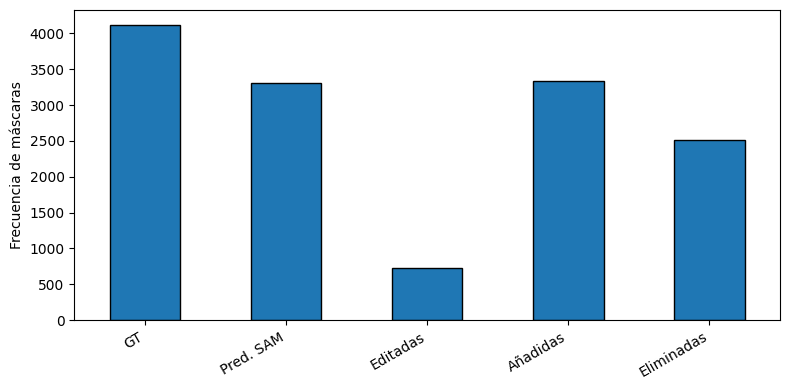

In [69]:
cols = ['n_masks_gt', 'n_masks_pred', 'n_masks_edited', 'n_masks_added', 'n_masks_deleted']

# 1) Resumim: total de màscares per cada tipus
sums = preann_SAM_data[cols].sum()

# 2) Diagrama de barres
plt.figure(figsize=(8, 4))
ax = sums.plot(
    kind='bar',
    edgecolor='black',
    linewidth=1.0
)

plt.ylabel("Frecuencia de máscaras")
plt.xticks(rotation=30, ha='right')

# Etiquetes més llegibles (opcionales)
ax.set_xticklabels([
    "GT",
    "Pred. SAM",
    "Editadas",
    "Añadidas",
    "Eliminadas"
])

plt.tight_layout()
plt.show()

In [45]:
preann_SAM_data['id'] = preann_SAM_data.file_name.str.replace(".jpg", "")
df_combined_ = pd.merge(preann_SAM_data, metadata_raw_data, on='id')
df_combined_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 60 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   file_name                  400 non-null    object        
 1   time_no_SAM                400 non-null    int64         
 2   time_pred                  400 non-null    float64       
 3   time_test                  400 non-null    int64         
 4   n_masks_gt                 400 non-null    int64         
 5   n_masks_pred               400 non-null    int64         
 6   n_masks_edited             400 non-null    int64         
 7   n_masks_added              400 non-null    int64         
 8   n_masks_deleted            400 non-null    int64         
 9   view                       400 non-null    object        
 10  night                      400 non-null    object        
 11  dry                        400 non-null    object        
 12  shadows 

In [46]:
df_combined_['time_diff'] = (df_combined_.time_test - df_combined_.time_no_SAM)
df_combined_['time_diff_pct'] = (df_combined_.time_test - df_combined_.time_no_SAM) / df_combined_.time_no_SAM

print(df_combined_['time_diff'].mean(), df_combined_['time_diff_pct'].mean())

-0.66 -0.0830053183293315


In [47]:
df_combined_.loc[df_combined_['time_diff'] > 0, 'improves'] = 'worse'
df_combined_.loc[df_combined_['time_diff'] < 0, 'improves'] = 'better'

print(df_combined_['improves'].value_counts())

improves
better    170
worse      41
Name: count, dtype: int64


In [89]:
counts = (
    df_combined_
    .groupby('stratum')['improves']
    .value_counts()
    .unstack(fill_value=0)          # columnes: better / equal / worse
)

# Taula de mitjanes per stratum
means = (
    df_combined_
    .groupby('stratum')
    .agg(
        mean_time_diff=('time_diff', 'mean'),
        mean_time_diff_pct=('time_diff_pct', 'mean')
    )
)

# Combinar-ho en una sola taula
summary = counts.join(means)

# Si vols que el percentatge surti en %
summary['mean_time_diff_pct'] = summary['mean_time_diff_pct'] * 100

summary = summary.reset_index()

summary = summary.round(3)

In [91]:
print(summary.to_latex(escape=False, index=False))

\begin{tabular}{lrrrr}
\toprule
stratum & better & worse & mean_time_diff & mean_time_diff_pct \\
\midrule
Q1 & 13 & 19 & 0.083000 & 5.494000 \\
Q2 & 48 & 21 & -0.259000 & -7.444000 \\
Q3 & 42 & 1 & -0.944000 & -17.467000 \\
Q4 & 67 & 0 & -2.000000 & -19.423000 \\
\bottomrule
\end{tabular}



In [92]:
counts_view = (
    df_combined_
    .groupby('view')['improves']
    .value_counts()
    .unstack(fill_value=0)          # columnes: better / equal / worse
)

# Mitjanes per view
means_view = (
    df_combined_
    .groupby('view')
    .agg(
        mean_time_diff=('time_diff', 'mean'),
        mean_time_diff_pct=('time_diff_pct', 'mean')
    )
)

# Combinar-ho en una sola taula
summary_view = counts_view.join(means_view)

# Passar el percentatge a %
summary_view['mean_time_diff_pct'] = summary_view['mean_time_diff_pct'] * 100

summary_view = summary_view.reset_index()

summary_view = summary_view.round(3)

In [93]:
print(summary_view.to_latex(escape=False, index=False))

\begin{tabular}{lrrrr}
\toprule
view & better & worse & mean_time_diff & mean_time_diff_pct \\
\midrule
general inf 45 & 66 & 16 & -0.752000 & -8.887000 \\
general sup 45 & 58 & 5 & -1.085000 & -12.644000 \\
primer inf 45 & 46 & 20 & -0.268000 & -4.640000 \\
\bottomrule
\end{tabular}



In [50]:
counts_dims_view = (
    df_combined_
    .groupby(['dims_cropped', 'view'])['improves']
    .value_counts()
    .unstack(fill_value=0)          # columnes: better / equal / worse
)

# Mitjanes per (dims_cropped, view)
means_dims_view = (
    df_combined_
    .groupby(['dims_cropped', 'view'])
    .agg(
        mean_time_diff=('time_diff', 'mean'),
        mean_time_diff_pct=('time_diff_pct', 'mean')
    )
)

# Combinar-ho en una sola taula
summary_dims_view = counts_dims_view.join(means_dims_view)

# Passar el percentatge a %
summary_dims_view['mean_time_diff_pct'] = summary_dims_view['mean_time_diff_pct'] * 100

# Si vols com a taula “normal” amb columnes explícites
summary_dims_view = summary_dims_view.reset_index()

summary_dims_view.round(3)

,dims_cropped,view,better,worse,mean_time_diff,mean_time_diff_pct
0,1280x544,general inf 45,6,0,-2.286,-20.636
1,1280x544,general sup 45,6,1,-1.500,-14.048
2,1280x544,primer inf 45,3,0,-0.800,-20.000
3,2992x3020,general inf 45,35,8,-0.598,-6.303
4,2992x3020,general sup 45,19,4,-0.725,-7.995
5,2992x3020,primer inf 45,30,8,-0.364,-8.831
6,4000x2259,general inf 45,3,4,-0.500,3.021
7,4000x2259,general sup 45,7,0,-1.357,-10.643
8,4000x2259,primer inf 45,5,0,-1.000,-25.938
9,720x816,general sup 45,1,0,-0.333,-4.762
